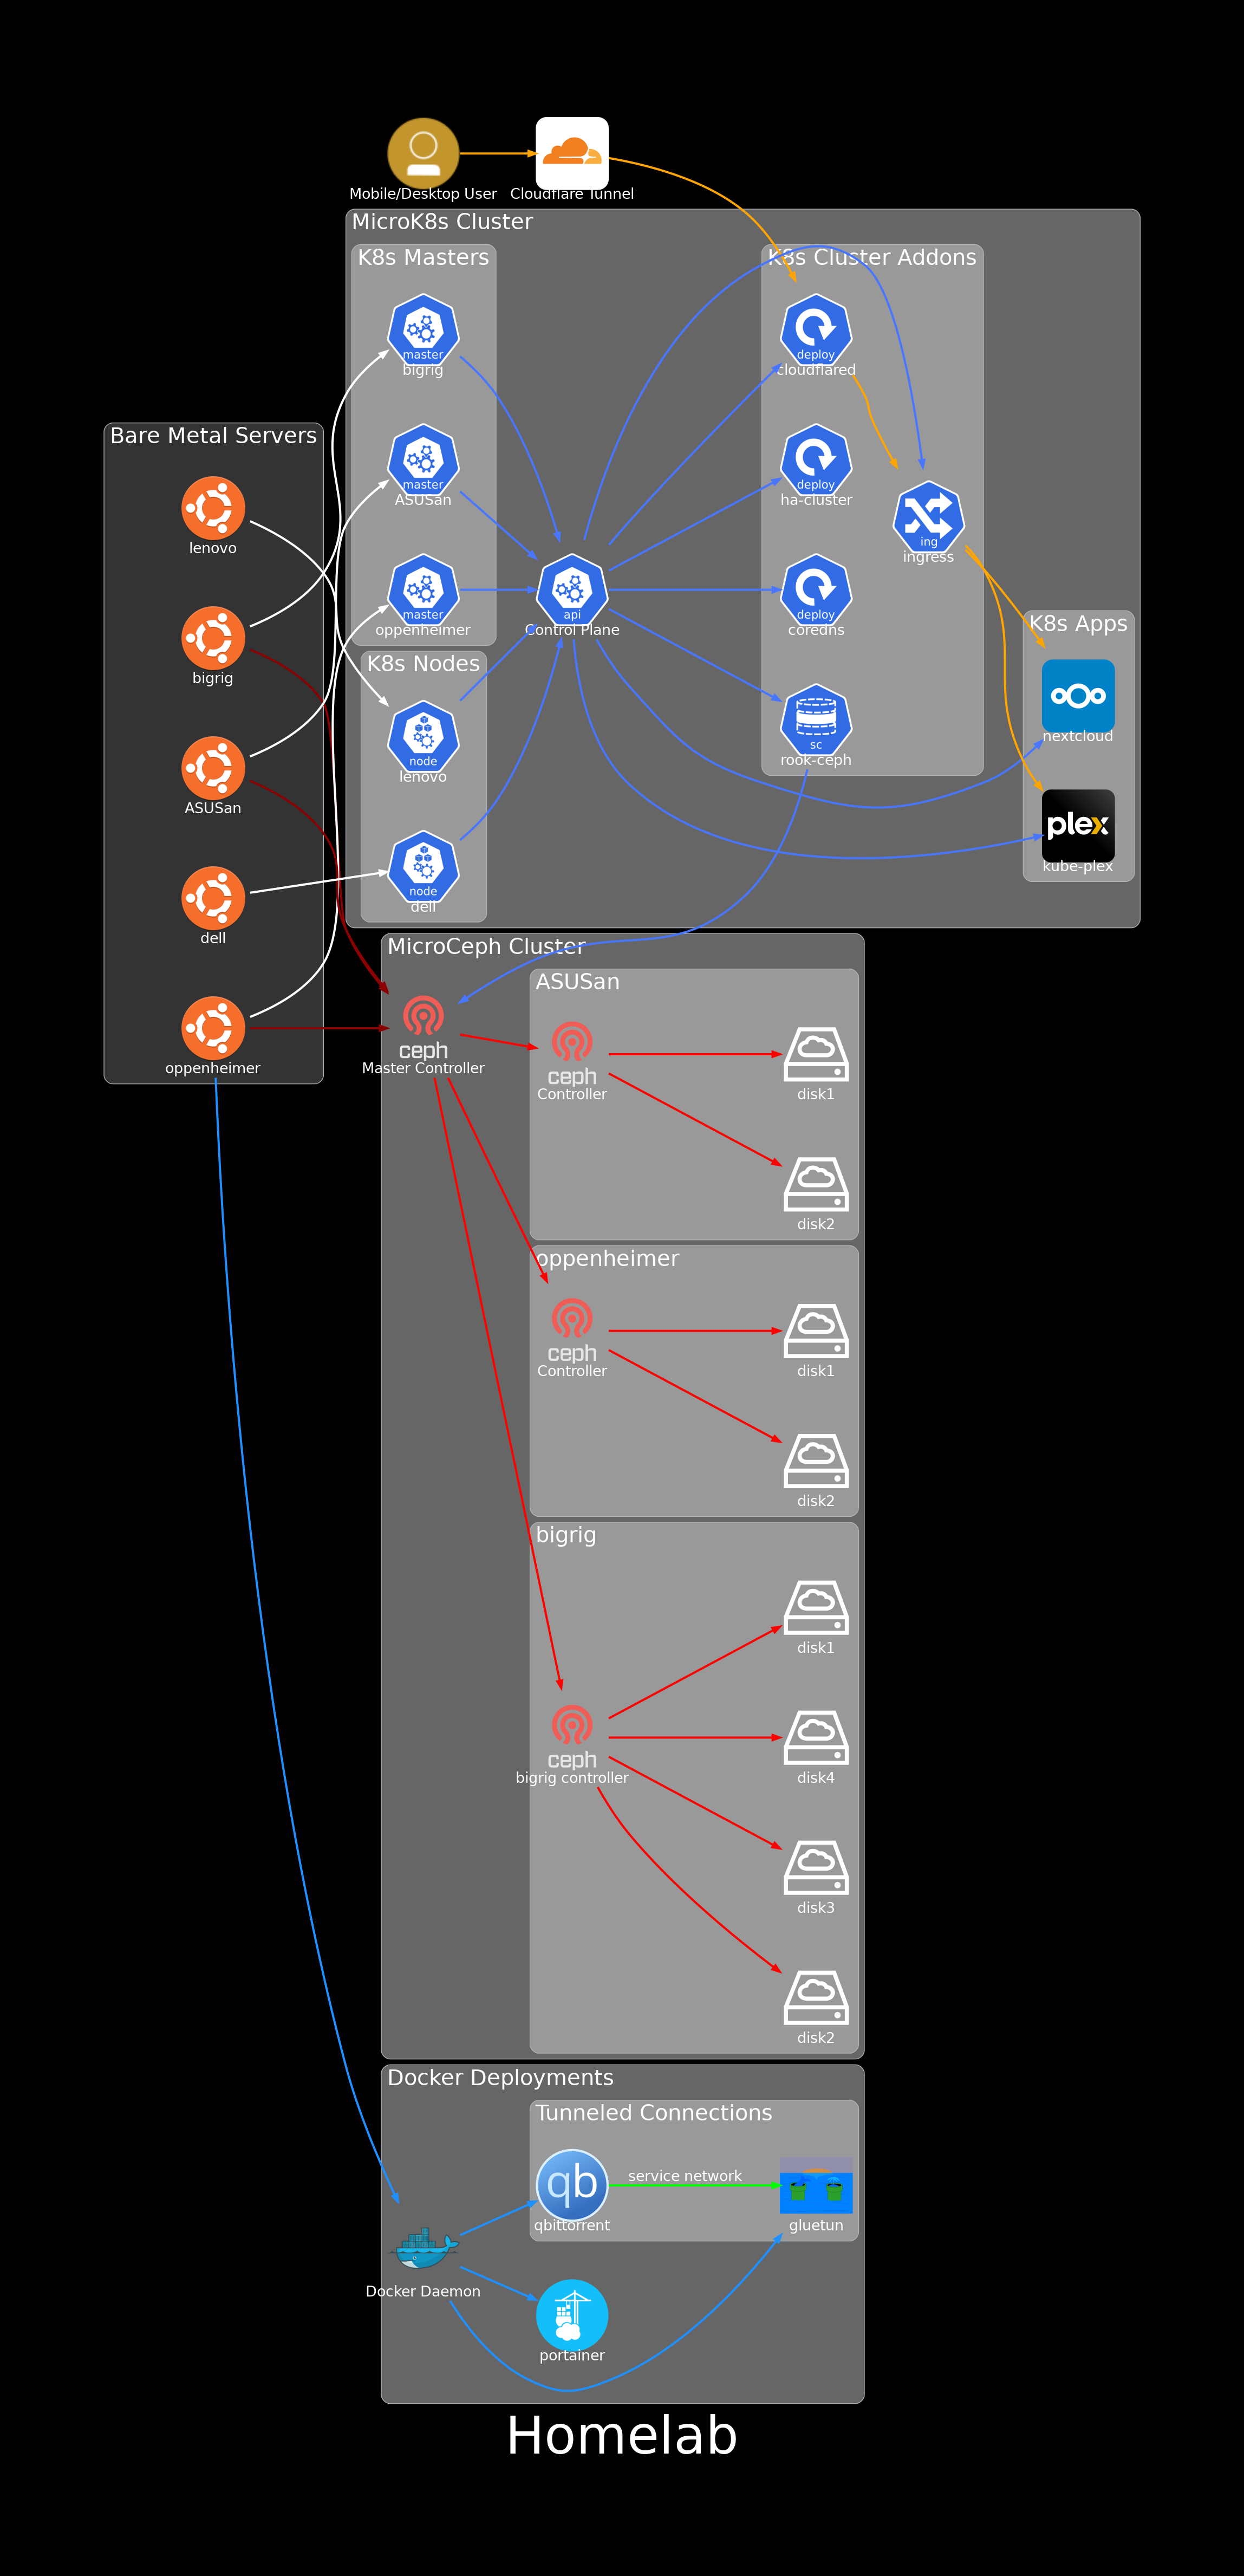

In [1]:
from diagrams                   import Diagram, Cluster, Edge
from diagrams.custom            import Custom
from diagrams.generic.os        import Ubuntu
from diagrams.k8s.compute       import Deployment
from diagrams.k8s.controlplane  import API
from diagrams.k8s.infra         import Master, Node
from diagrams.k8s.network       import Ingress
from diagrams.k8s.storage       import StorageClass
from diagrams.oci.storage       import StorageGatewayWhite
from diagrams.ibm.user          import User
from diagrams.onprem.container  import Docker

# Attributes
## node
base_node_attr = { "fontcolor": "white", "fontsize": "20", "margin": "0.11,0.1" }
## edge
base_edge_attr           = { "color": "white", "penwidth": "3", "overlap": "false" }
k8s_edge_attr            = base_edge_attr | { "color": "royalblue1" }
user_edge_attr           = base_edge_attr | { "color": "orange" }
bmetal_k8s_edge_attr     = base_edge_attr | { "color": "white" }
docker_edge_attr         = base_edge_attr | { "color": "dodgerblue" }
gluetun_tunnel_edge_attr = base_edge_attr | { "color": "green", "fontcolor": "white", "fontsize": "20" }
## cluster
cluster1_attr  = { "fontcolor": "white", "fontsize": "30", "bgcolor": "gray40" }
baremetal_attr = cluster1_attr | { "bgcolor": "gray20" }
cluster2_attr  = { "fontcolor": "white", "fontsize": "30", "bgcolor": "gray60" }
diagram_attr   = { "fontcolor": "white", "fontsize": "72", "bgcolor": "black", "layout": "dot", "overlap": "false", "splines": "true" }

# Clusters and Nodes
with Diagram("Homelab", graph_attr=diagram_attr) as diag:
    user = User("Mobile/Desktop User", **base_node_attr)
    cloudflare_tunnel  = Custom("Cloudflare Tunnel", "./custom_icons/cloudflare.png", **base_node_attr)

    with Cluster("Bare Metal Servers", graph_attr=baremetal_attr) as baremetal_cluster:
        bigrig      = Ubuntu("bigrig", **base_node_attr)
        oppenheimer = Ubuntu("oppenheimer", **base_node_attr)
        ASUSan      = Ubuntu("ASUSan", **base_node_attr)
        blueberry   = Ubuntu("blueberry", **base_node_attr)

        baremetal_servers = [oppenheimer, bigrig, ASUSan, blueberry]
    
    with Cluster("MicroK8s Cluster", graph_attr=cluster1_attr) as microk8s_cluster:
        k8s_controlplane = API("Control Plane", **base_node_attr)
        with Cluster("K8s Masters", graph_attr=cluster2_attr) as k8s_master3s_cluster:
            k8s_oppenheimer = Master("oppenheimer", **base_node_attr)
            k8s_bigrig      = Master("bigrig", **base_node_attr)
            k8s_ASUSan      = Master("ASUSan",**base_node_attr)
            k8s_blueberry   = Master("blueberry", **base_node_attr)

            k8s_masters = [k8s_oppenheimer, k8s_bigrig, k8s_ASUSan]

        with Cluster("K8s Nodes", graph_attr=cluster2_attr) as k8s_nodes_cluster:
            k8s_lenovo  = Node("lenovo", **base_node_attr)
            k8s_dell    = Node("dell", **base_node_attr)

            k8s_nodes = [k8s_lenovo, k8s_dell]

        with Cluster("K8s Apps", graph_attr=cluster2_attr) as k8s_deployments_cluster:
            kube_plex = Custom("kube-plex", "./custom_icons/plex.png", **base_node_attr)
            nextcloud = Custom("nextcloud", "./custom_icons/nextcloud.png", **base_node_attr)

            k8s_deployments = [kube_plex, nextcloud]

        with Cluster("K8s Cluster Addons", graph_attr=cluster2_attr) as k8s_addons_cluster:
            coredns     = Deployment("coredns", **base_node_attr)
            ha_cluster  = Deployment("ha-cluster", **base_node_attr)
            cloudflared = Deployment("cloudflared", **base_node_attr)
            ingress     = Ingress("ingress", **base_node_attr)


    with Cluster("Docker Deployments", graph_attr=cluster1_attr) as docker_deployments_cluster:
        portainer     = Custom("portainer", "./custom_icons/portainer.png", **base_node_attr)
        docker_master = Docker("Docker Daemon", **base_node_attr)
        
        with Cluster("Tunneled Connections", graph_attr=cluster2_attr) as tunneled_connections:
            gluetun       = Custom("gluetun", "./custom_icons/gluetun.png", **base_node_attr)
            qbittorrent   = Custom("qbittorrent", "./custom_icons/qbittorrent.png", **base_node_attr)

        docker_deployments = [portainer, gluetun, qbittorrent]

# Edge Connections
## baremetal nodes to k8s nodes
oppenheimer >> Edge(**bmetal_k8s_edge_attr) >> k8s_oppenheimer
bigrig      >> Edge(**bmetal_k8s_edge_attr) >> k8s_bigrig
ASUSan      >> Edge(**bmetal_k8s_edge_attr) >> k8s_ASUSan
lenovo      >> Edge(**bmetal_k8s_edge_attr) >> k8s_lenovo
dell        >> Edge(**bmetal_k8s_edge_attr) >> k8s_dell


## Baremetal to docker deployments
oppenheimer     >> Edge(**docker_edge_attr) >> docker_master
docker_master   >> Edge(**docker_edge_attr) >> docker_deployments
qbittorrent     >> Edge(**gluetun_tunnel_edge_attr, label="service network") >> gluetun

## k8s nodes
k8s_controlplane >> Edge(**k8s_edge_attr)   >> k8s_deployments
k8s_controlplane >> Edge(**k8s_edge_attr)   >> k8s_cluster_addons
ingress          >> Edge(**user_edge_attr)  >> k8s_deployments
k8s_nodes        >> Edge(**k8s_edge_attr)   >> k8s_controlplane
k8s_masters      >> Edge(**k8s_edge_attr)   >> k8s_controlplane




## end user interactions
user                >> Edge(**user_edge_attr) >> cloudflare_tunnel
cloudflare_tunnel   >> Edge(**user_edge_attr) >> cloudflared
cloudflared         >> Edge(**user_edge_attr) >> ingress


diag